In [1]:
import os
from mpl_toolkits.basemap import Basemap, cm, shiftgrid,maskoceans
from netCDF4 import Dataset as NetCDFFile
import numpy as np
import numpy.ma as ma
import matplotlib.pyplot as plt
from matplotlib import colors, ticker
import numpy.ma as ma
from scipy.interpolate import griddata
#from pyresample import geometry,image, kd_tree
import copy
import isamcalc_lib as isam

In [2]:
# Figure to show the latitudinal distribution of O2 limitation and N limitation

# Open 1860s file
path='Global_1DSBGC.bgc-yearly-3d_1860s.nc'
nclu=NetCDFFile(path,'r')
fo2_1860 = nclu.variables['fo2'][:]
fna_1860 = nclu.variables['fna'][:]
latnc = nclu.variables['lat'][:]
lonnc = nclu.variables['lon'][:]
nclu.close()

# Open 2000s file
path='Global_1DSBGC.bgc-yearly-3d_2000s.nc'
nclu=NetCDFFile(path,'r')
fo2_2000 = nclu.variables['fo2'][:]
fna_2000 = nclu.variables['fna'][:]
latnc = nclu.variables['lat'][:]
lonnc = nclu.variables['lon'][:]
nclu.close()

# Get the PFT fraction
flc = 'verify_time_invarient.nc'
nclu_obs=NetCDFFile(flc,'r')
lc = nclu_obs.variables['c_pft_fraction'][:]
nclu_obs.close()

# Get latitudinal profile of O2 limitation
fo2 = fo2_1860
# For Fo2, Aggregate to 1m
fo2[fo2<=0] = np.float('nan')
z, dz, zsoih = isam.get_isam_soildp(10)
z_accu = 0.
fo2_accu = 0.*fo2[0,:,:]
for i in np.arange(0,8):
    if(i==7):
        fo2[i,:,:] = 0.2*fo2[i,:,:]
        z_accu = z_accu + 0.2
        fo2_accu = fo2_accu + fo2[i,:,:]
    else:
        fo2[i,:,:] = dz[i]*fo2[i,:,:]
        z_accu = z_accu + dz[i]
        fo2_accu = fo2_accu + fo2[i,:,:]
    if(i==7):
        fo2_accu = fo2_accu/z_accu
fo2_accu_1860 = copy.deepcopy(fo2_accu)
fo2_1860_latmean = np.nanmean(fo2_accu_1860, axis=1)

fo2 = fo2_2000
# For Fo2, Aggregate to 1m
fo2[fo2<=0] = np.float('nan')
z, dz, zsoih = isam.get_isam_soildp(10)
z_accu = 0.
fo2_accu = 0.*fo2[0,:,:]
for i in np.arange(0,8):
    if(i==7):
        fo2[i,:,:] = 0.2*fo2[i,:,:]
        z_accu = z_accu + 0.2
        fo2_accu = fo2_accu + fo2[i,:,:]
    else:
        fo2[i,:,:] = dz[i]*fo2[i,:,:]
        z_accu = z_accu + dz[i]
        fo2_accu = fo2_accu + fo2[i,:,:]
    if(i==7):
        fo2_accu = fo2_accu/z_accu
fo2_accu_2000 = copy.deepcopy(fo2_accu)
fo2_2000_latmean = np.nanmean(fo2_accu_2000, axis=1)

# Get latitudinal profile of N limitation
fna = fna_1860
fna[fna<=0] = 1.
for i in np.arange(0,24):
    fna[i,:,:] = lc[i,:,:]*fna[i,:,:]
fna_avg = np.nansum(fna, axis=0)
fna_1860_avg = copy.deepcopy(fna_avg)
fna_1860_latmean = np.nanmean(fna_1860_avg, axis=1)

fna = fna_2000
fna[fna<=0] = 1.
for i in np.arange(0,24):
    fna[i,:,:] = lc[i,:,:]*fna[i,:,:]
fna_avg = np.nansum(fna, axis=0)
fna_2000_avg = copy.deepcopy(fna_avg)
fna_2000_latmean = np.nanmean(fna_2000_avg, axis=1)


In [4]:
np.shape(fna_2000_latmean)

(360L,)

In [8]:
fo2_1860_latmean = np.nanmean(fo2_accu_1860_perm, axis=1)

fo2_2000_latmean = np.nanmean(fo2_accu_2000_perm, axis=1)

fna_1860_latmean = np.nanmean(fna_1860_avg_perm, axis=1)

fna_2000_latmean = np.nanmean(fna_2000_avg_perm, axis=1)

C:\Users\sshu3\Anaconda2\lib\site-packages\ipykernel_launcher.py:1: RuntimeWarning: Mean of empty slice
  """Entry point for launching an IPython kernel.
C:\Users\sshu3\Anaconda2\lib\site-packages\ipykernel_launcher.py:3: RuntimeWarning: Mean of empty slice
  This is separate from the ipykernel package so we can avoid doing imports until


Text(0,0.5,'N availability')

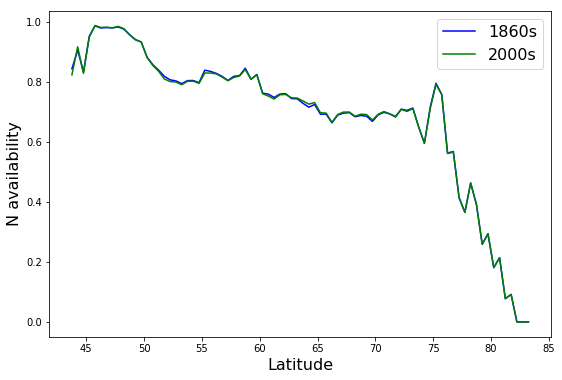

In [9]:
plt.figure(figsize=(9,6))
latnc[1:220] = np.float('nan')
plt.plot(latnc,fna_1860_latmean, 'b-')
plt.plot(latnc,fna_2000_latmean, 'g-')
#plt.set_xlabel('Latitude', fontsize=20, labelpad=0)
plt.legend(['1860s', '2000s'], fontsize=16)
plt.xlabel('Latitude', fontsize=16)
plt.ylabel('N availability', fontsize=16)
#plt.savefig('figs7.png')

Text(0,0.5,'O2 availability')

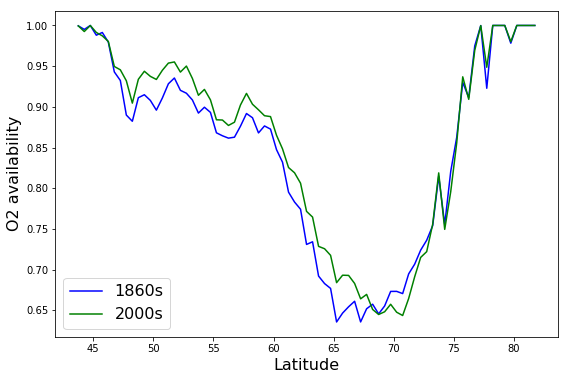

In [10]:
plt.figure(figsize=(9,6))
# Latitudinal plot to show FO2
latnc[1:220] = np.float('nan')
plt.plot(latnc, fo2_1860_latmean, 'b-')
plt.plot(latnc, fo2_2000_latmean, 'g-')
plt.legend(['1860s', '2000s'], fontsize=16)
plt.xlabel('Latitude', fontsize=16)
plt.ylabel('O2 availability', fontsize=16)
#plt.savefig('figs8.png')

In [ ]:
for i in np.arange(0,10):
    rc14c12_all[i,:,:] = np.sum((rc14c12[i,:,:,:] * lc), axis=0)

In [71]:
np.nanmean(fo2_2000_latmean[280:360])

0.8586453409489274

In [72]:
np.nanmean(fna_2000_latmean[280:360])

0.8459178651635393

In [3]:
# Filter out abnormal values.
# fo2_accu_1860[fo2_accu_1860>=0.9] = 0.9
# fo2_accu_2000[fo2_accu_2000>=0.9] = 0.9
fo2_accu_1860[fo2_accu_1860<=0.5] = 0.5
fo2_accu_2000[fo2_accu_2000<=0.5] = 0.5

# Open and apply mask
# Option
dave_mc=False

# Open NCSCD as observation
path='ncscdv2_soilc_0.5x0.5.nc'
nclu_obs=NetCDFFile(path,'r')
soc_ncscd_orig = nclu_obs.variables['soilc'][:]
latnc2 = nclu_obs.variables['lat'][:]
lonnc2 = nclu_obs.variables['lon'][:]
nclu_obs.close()
soc_ncscd = soc_ncscd_orig[0,:,:]

# Use the NCSCD permafrost mask, which is the norther high latitude permafrost region without greenland
# The mask Mcguire et al., 2016 used including alpine permafrost (Tiebet and the Alps)
# Alpine permafrost to be treated as having a very small amount of SOC, though for the paper we have 
# to consider the whole region.
mask_permafrost = copy.deepcopy(ma.getmask(soc_ncscd))
another_mask = ma.masked_where(soc_ncscd<=0, soc_ncscd)
temp = copy.deepcopy(mask_permafrost[:, 0:360])
mask_permafrost[:, 0:360] = mask_permafrost[:, 360:720]
mask_permafrost[:, 360:720] = temp
temp = copy.deepcopy(another_mask[:, 0:360])
another_mask[:, 0:360] = another_mask[:, 360:720]
another_mask[:, 360:720] = temp
#new_mask = np.logical_or(another_mask, mask_permafrost)

# Mask all regions outside the northern permafrost extent
fo2_accu_1860_perm = copy.deepcopy(fo2_accu_1860)
fo2_accu_1860_perm.mask = another_mask.mask
fo2_accu_2000_perm = copy.deepcopy(fo2_accu_2000)
fo2_accu_2000_perm.mask = another_mask.mask

fna_1860_avg_perm = copy.deepcopy(fna_1860_avg)
fna_1860_avg_perm.mask = another_mask.mask
fna_2000_avg_perm = copy.deepcopy(fna_2000_avg)
fna_2000_avg_perm.mask = another_mask.mask


C:\Users\sshu3\Anaconda2\lib\site-packages\ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in less_equal
  after removing the cwd from sys.path.
C:\Users\sshu3\Anaconda2\lib\site-packages\ipykernel_launcher.py:5: RuntimeWarning: invalid value encountered in less_equal
  """


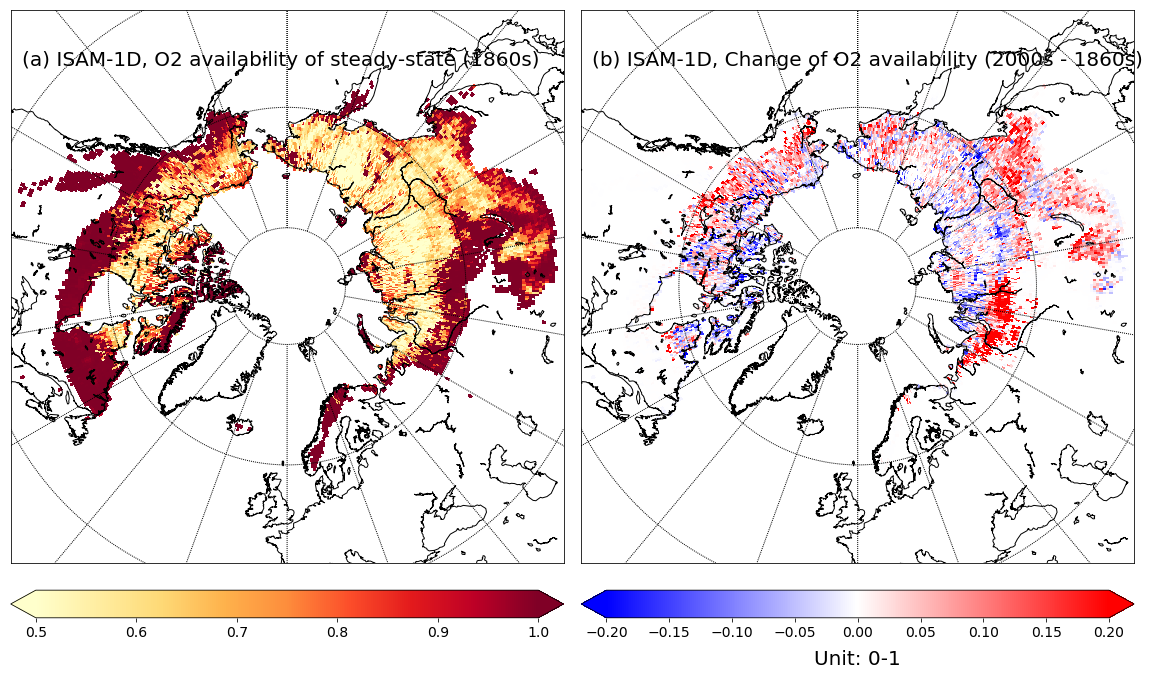

In [50]:
# Plot the figure S5 and S6
# FO2, 1860s value and 2000s - 1860s diff
fig = plt.figure(figsize=(16,10))

ax1 = fig.add_subplot(121)
#ax1.set_title("ISAM-0D SOC stock (1m)",fontsize=32,pad=15)
map = Basemap(projection='npstere',boundinglat=45,lon_0=0,resolution='l')
# draw coastlines, state and country boundaries, edge of map.
map.drawcoastlines()
#map.drawstates()
#map.drawcountries(color='b')
lon,lat = np.meshgrid(lonnc,latnc) #Returns coordinate matrices from coordinate vectors
x,y = map(lon,lat)


clevs = np.power(10.0, np.arange(-1.0,2.5,0.5))
cs1 = map.pcolormesh(x,y,fo2_accu_1860_perm[:,:],
              norm=colors.Normalize(vmin=0.5,vmax=1.0),cmap=plt.cm.YlOrRd) # use log color scale,
# Overlap scatter plot to show the peatland distribution
#map.scatter(xs, ys, s = 4*histosol, latlon=True, marker='_', color='cyan')
#map.scatter(xs, ys, s = 4*histel, latlon=True, marker='_', color='cyan')
cbar = map.colorbar(cs1,location='bottom',pad="5%",extend='both')
plt.annotate('(a) ISAM-1D, O2 availability of steady-state (1860s)', fontsize=20, xy=(0.02, 0.9), xycoords='axes fraction')
#parallels = np.arange(45.,80.,15.)
## labels = [left,right,top,bottom]
#map.drawparallels(parallels)#,labels=[False,True,True,False])
#meridians = np.arange(15.,346.,30.)
#map.drawmeridians(meridians)#,labels=[True,False,False,True])

map.drawparallels(np.arange(-80.,81.,20.))#, labels=[True,True,True,True])
map.drawmeridians(np.arange(-180.,181.,20.))#, labels=[True,True,True,True])
cbar.ax.tick_params(labelsize=14) 

ax2 = fig.add_subplot(122)
#ax2.set_title("ISAM-1D SOC stock (1m)",fontsize=32,pad=15)
map = Basemap(projection='npstere',boundinglat=45,lon_0=0,resolution='l')
# draw coastlines, state and country boundaries, edge of map.
map.drawcoastlines()
#map.drawstates()
#map.drawcountries(color='b')
cs = map.pcolormesh(x,y,fo2_accu_2000_perm[:,:]-fo2_accu_1860_perm[:,:],
              norm=colors.Normalize(vmin=-0.2,vmax=0.2),cmap=plt.cm.bwr) # use log color scale,
                                                      # omit this to use linear
                                                     # color scale
#map.scatter(xs, ys, s = 0.4*histosol, latlon=True, marker='_', color='cyan')
#map.scatter(xs, ys, s = 0.4*histel, latlon=True, marker='_', color='cyan')
map.drawparallels(np.arange(-80.,81.,20.))#, labels=[True,True,True,True])
map.drawmeridians(np.arange(-180.,181.,20.))#, labels=[True,True,True,True])
cbar = map.colorbar(cs,location='bottom',pad="5%",extend='both')
cbar.ax.set_xlabel('Unit: 0-1', fontsize=20, labelpad=10)
plt.annotate('(b) ISAM-1D, Change of O2 availability (2000s - 1860s)', fontsize=20, xy=(0.02, 0.9), xycoords='axes fraction')
cbar.ax.tick_params(labelsize=14) 

plt.tight_layout()
#plt.show()
plt.savefig('figs5.png',dpi=300)

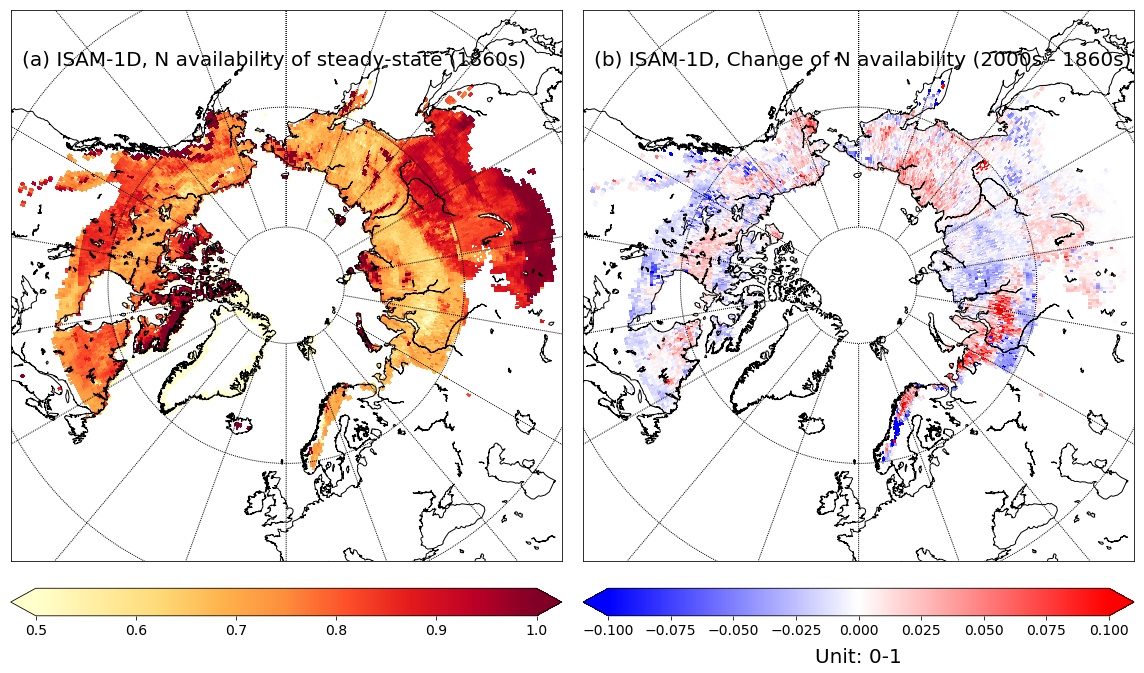

In [52]:
# Plot the figure S5 and S6
# FO2, 1860s value and 2000s - 1860s diff
fig = plt.figure(figsize=(16,10))

ax1 = fig.add_subplot(121)
#ax1.set_title("ISAM-0D SOC stock (1m)",fontsize=32,pad=15)
map = Basemap(projection='npstere',boundinglat=45,lon_0=0,resolution='l')
# draw coastlines, state and country boundaries, edge of map.
map.drawcoastlines()
#map.drawstates()
#map.drawcountries(color='b')
lon,lat = np.meshgrid(lonnc,latnc) #Returns coordinate matrices from coordinate vectors
x,y = map(lon,lat)

clevs = np.power(10.0, np.arange(-1.0,2.5,0.5))
cs1 = map.pcolormesh(x,y,fna_1860_avg_perm[:,:],
              norm=colors.Normalize(vmin=0.5,vmax=1.0),cmap=plt.cm.YlOrRd) # use log color scale,
# Overlap scatter plot to show the peatland distribution
#map.scatter(xs, ys, s = 4*histosol, latlon=True, marker='_', color='cyan')
#map.scatter(xs, ys, s = 4*histel, latlon=True, marker='_', color='cyan')
cbar = map.colorbar(cs1,location='bottom',pad="5%",extend='both')
plt.annotate('(a) ISAM-1D, N availability of steady-state (1860s)', fontsize=20, xy=(0.02, 0.9), xycoords='axes fraction')
#parallels = np.arange(45.,80.,15.)
## labels = [left,right,top,bottom]
#map.drawparallels(parallels)#,labels=[False,True,True,False])
#meridians = np.arange(15.,346.,30.)
#map.drawmeridians(meridians)#,labels=[True,False,False,True])

map.drawparallels(np.arange(-80.,81.,20.))#, labels=[True,True,True,True])
map.drawmeridians(np.arange(-180.,181.,20.))#, labels=[True,True,True,True])
cbar.ax.tick_params(labelsize=14) 

ax2 = fig.add_subplot(122)
#ax2.set_title("ISAM-1D SOC stock (1m)",fontsize=32,pad=15)
map = Basemap(projection='npstere',boundinglat=45,lon_0=0,resolution='l')
# draw coastlines, state and country boundaries, edge of map.
map.drawcoastlines()
#map.drawstates()
#map.drawcountries(color='b')
cs = map.pcolormesh(x,y,fna_2000_avg_perm[:,:]-fna_1860_avg_perm[:,:],
              norm=colors.Normalize(vmin=-0.1,vmax=0.1),cmap=plt.cm.bwr) # use log color scale,
                                                      # omit this to use linear
                                                     # color scale
#map.scatter(xs, ys, s = 0.4*histosol, latlon=True, marker='_', color='cyan')
#map.scatter(xs, ys, s = 0.4*histel, latlon=True, marker='_', color='cyan')
map.drawparallels(np.arange(-80.,81.,20.))#, labels=[True,True,True,True])
map.drawmeridians(np.arange(-180.,181.,20.))#, labels=[True,True,True,True])
cbar = map.colorbar(cs,location='bottom',pad="5%",extend='both')
cbar.ax.set_xlabel('Unit: 0-1', fontsize=20, labelpad=10)
plt.annotate('(b) ISAM-1D, Change of N availability (2000s - 1860s)', fontsize=20, xy=(0.02, 0.9), xycoords='axes fraction')
cbar.ax.tick_params(labelsize=14) 


plt.tight_layout()
#plt.show()
plt.savefig('figs6.png',dpi=300)


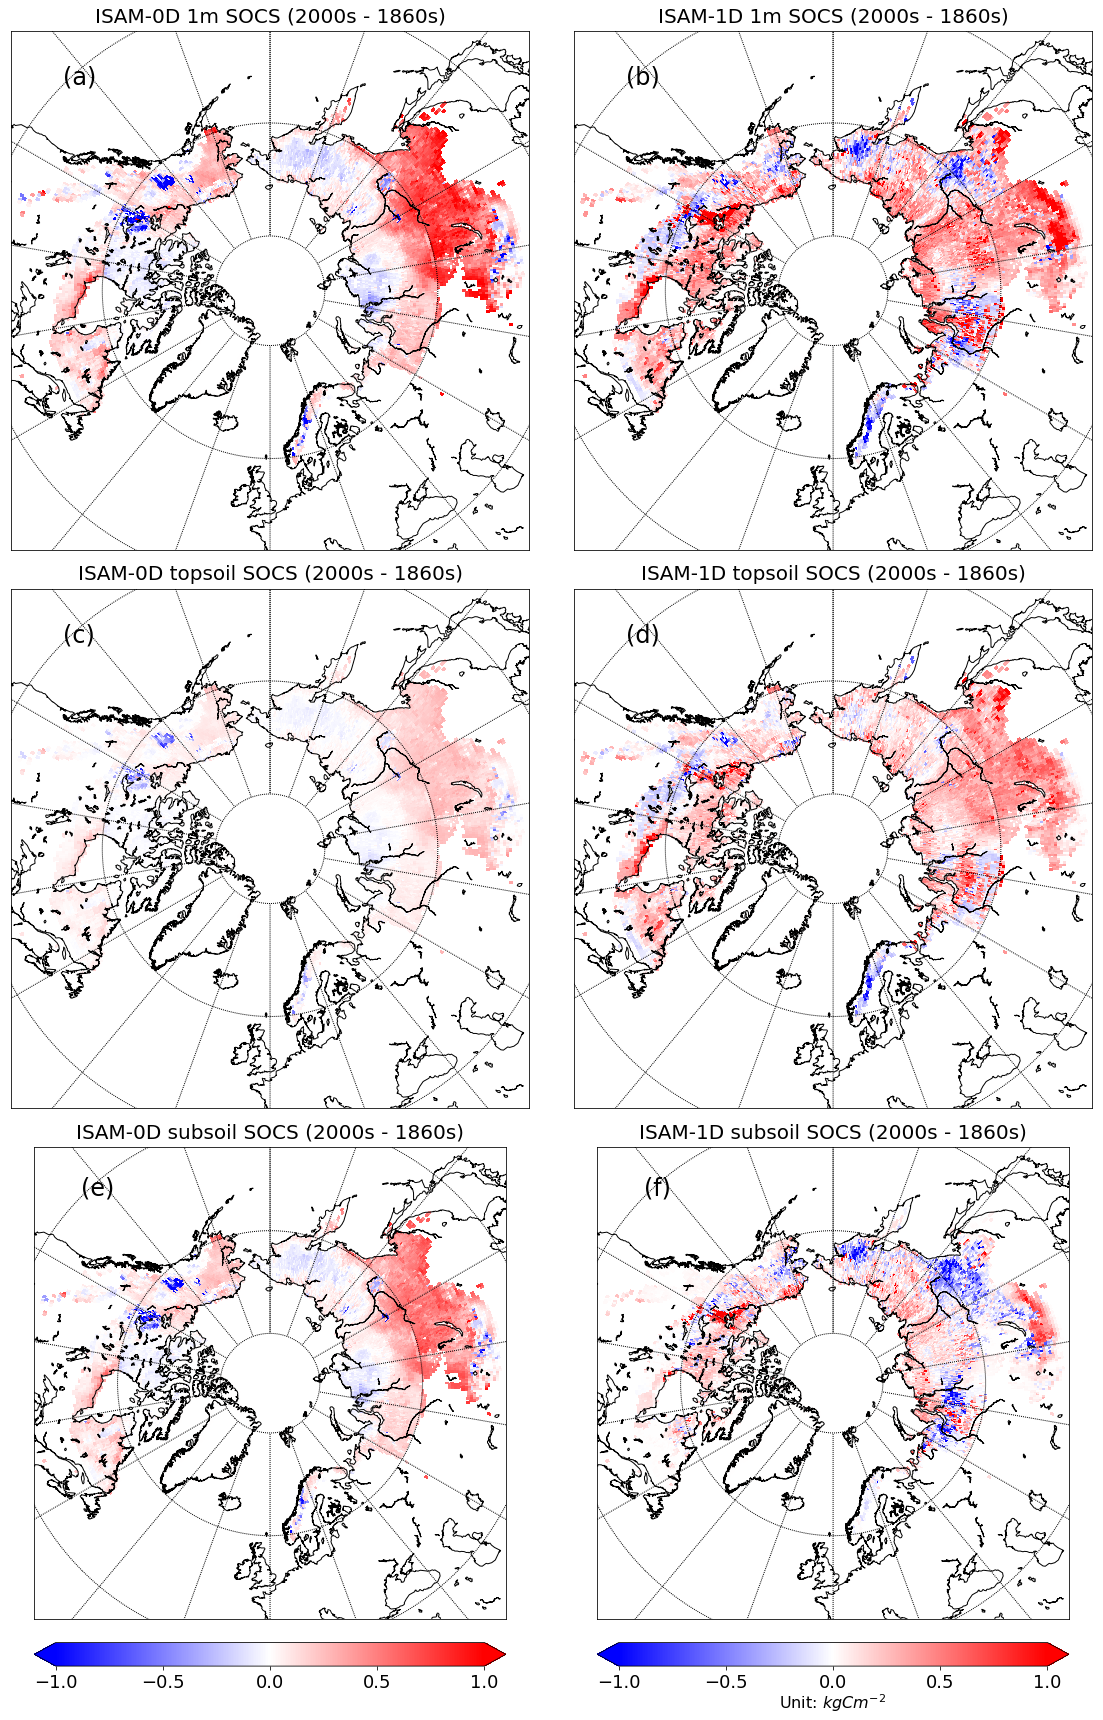

In [31]:
# Mask all regions outside the northern permafrost extent
dsoc_perm = copy.deepcopy(dsoc)
dsoc_perm.mask = another_mask.mask
dsoc_top_perm = copy.deepcopy(dsoc_topsoil)
dsoc_top_perm.mask = another_mask.mask
dsoc_sub_perm = copy.deepcopy(dsoc_subsoil)
dsoc_sub_perm.mask = another_mask.mask

dsoc0d_perm = copy.deepcopy(dsoc0d)
dsoc0d_perm.mask = another_mask.mask
dsoc0d_top_perm = copy.deepcopy(dsoc0d_topsoil)
dsoc0d_top_perm.mask = another_mask.mask
dsoc0d_sub_perm = copy.deepcopy(dsoc0d_subsoil)
dsoc0d_sub_perm.mask = another_mask.mask

dtau_perm = copy.deepcopy(dtau)
dtau_perm.mask = another_mask.mask
dtau0d_perm = copy.deepcopy(dtau0d)
dtau0d_perm.mask = another_mask.mask

# Mask the strange results around greenland

# Plot the figure7
# Comparison of 1m SOC stock between two models and to the NCSCD data
fig = plt.figure(figsize=(16,24))

#ax1 = fig.add_subplot(331)
ax1 = fig.add_subplot(321)
ax1.set_title("ISAM-0D 1m SOCS (2000s - 1860s)",fontsize=20,pad=10)
map = Basemap(projection='npstere',boundinglat=45,lon_0=0,resolution='l')
# draw coastlines, state and country boundaries, edge of map.
map.drawcoastlines()
#map.drawstates()
#map.drawcountries(color='b')
lon,lat = np.meshgrid(lonnc,latnc) #Returns coordinate matrices from coordinate vectors
x,y = map(lon,lat)
cs1 = map.pcolormesh(x,y,dsoc0d_perm[:,:],
              norm=colors.Normalize(vmin=-1.,vmax=1.),cmap=plt.cm.bwr) # use log color scale,
#cbar = map.colorbar(cs1,ticks=[-1, -0.5, 0, 0.5, 1],location='bottom',pad="5%",extend='both')
map.drawparallels(np.arange(-80.,81.,20.))#, labels=[True,True,True,True])
map.drawmeridians(np.arange(-180.,181.,20.))#, labels=[True,True,True,True])
plt.annotate('(a)', fontsize=24, xy=(0.1, 0.9), xycoords='axes fraction')
#cbar.ax.tick_params(labelsize=22) 

ax2 = fig.add_subplot(322)
ax2.set_title("ISAM-1D 1m SOCS (2000s - 1860s)",fontsize=20,pad=10)
map = Basemap(projection='npstere',boundinglat=45,lon_0=0,resolution='l')
# draw coastlines, state and country boundaries, edge of map.
map.drawcoastlines()
#map.drawstates()
#map.drawcountries(color='b')
cs2 = map.pcolormesh(x,y,dsoc_perm[:,:],
              norm=colors.Normalize(vmin=-1.,vmax=1.),cmap=plt.cm.bwr) # use log color scale,
                                                      # omit this to use linear
                                                     # color scale
#cbar = map.colorbar(cs2,ticks=[-1, -0.5, 0, 0.5, 1],location='bottom',pad="5%",extend='both')
map.drawparallels(np.arange(-80.,81.,20.))#, labels=[True,True,True,True])
map.drawmeridians(np.arange(-180.,181.,20.))#, labels=[True,True,True,True])
#cbar.ax.set_xlabel('Unit: $kgC m^{-2}$', fontsize=20, labelpad=0)
plt.annotate('(b)', fontsize=24, xy=(0.1, 0.9), xycoords='axes fraction')
#cbar.ax.tick_params(labelsize=22)

ax3 = fig.add_subplot(323)
ax3.set_title("ISAM-0D topsoil SOCS (2000s - 1860s)",fontsize=20,pad=10)
map = Basemap(projection='npstere',boundinglat=45,lon_0=0,resolution='l')
# draw coastlines, state and country boundaries, edge of map.
map.drawcoastlines()
#map.drawstates()
#map.drawcountries(color='b')
cs3 = map.pcolormesh(x,y,dsoc0d_top_perm[:,:],
#              norm=colors.Normalize(vmin=-300,vmax=300.),cmap=plt.cm.coolwarm) # use log color scale,
              norm=colors.Normalize(vmin=-1.,vmax=1.),cmap=plt.cm.bwr) # use log color scale,
                                                      # omit this to use linear
                                                     # color scale
#cbar = map.colorbar(cs2,ticks=[-1, -0.5, 0, 0.5, 1],location='bottom',pad="5%",extend='both')
map.drawparallels(np.arange(-80.,81.,20.))#, labels=[True,True,True,True])
map.drawmeridians(np.arange(-180.,181.,20.))#, labels=[True,True,True,True])
plt.annotate('(c)', fontsize=24, xy=(0.1, 0.9), xycoords='axes fraction')
#cbar.ax.tick_params(labelsize=22) 

ax4 = fig.add_subplot(324)
ax4.set_title("ISAM-1D topsoil SOCS (2000s - 1860s)",fontsize=20,pad=10)
map = Basemap(projection='npstere',boundinglat=45,lon_0=0,resolution='l')
# draw coastlines, state and country boundaries, edge of map.
map.drawcoastlines()
#map.drawstates()
#map.drawcountries(color='b')
cs4 = map.pcolormesh(x,y,dsoc_top_perm[:,:],
#              norm=colors.Normalize(vmin=-60.,vmax=60.),cmap=plt.cm.coolwarm) # use log color scale,
              norm=colors.Normalize(vmin=-1.,vmax=1.),cmap=plt.cm.bwr) # use log color scale,

#cbar = map.colorbar(cs2,ticks=[-1, -0.5, 0, 0.5, 1],location='bottom',pad="5%",extend='both')
#cbar.ax.set_xlabel('Unit: $kgC m^{-2}$', fontsize=20, labelpad=0)
map.drawparallels(np.arange(-80.,81.,20.))#, labels=[True,True,True,True])
map.drawmeridians(np.arange(-180.,181.,20.))#, labels=[True,True,True,True])
plt.annotate('(d)', fontsize=24, xy=(0.1, 0.9), xycoords='axes fraction')
#cbar.ax.tick_params(labelsize=22)

ax3 = fig.add_subplot(325)
ax3.set_title("ISAM-0D subsoil SOCS (2000s - 1860s)",fontsize=20,pad=10)
map = Basemap(projection='npstere',boundinglat=45,lon_0=0,resolution='l')
# draw coastlines, state and country boundaries, edge of map.
map.drawcoastlines()
#map.drawstates()
#map.drawcountries(color='b')
cs3 = map.pcolormesh(x,y,dsoc0d_sub_perm[:,:],
#              norm=colors.Normalize(vmin=-300,vmax=300.),cmap=plt.cm.coolwarm) # use log color scale,
              norm=colors.Normalize(vmin=-1.,vmax=1.),cmap=plt.cm.bwr) # use log color scale,
                                                      # omit this to use linear
                                                     # color scale
cbar = map.colorbar(cs2,ticks=[-1, -0.5, 0, 0.5, 1],location='bottom',pad="5%",extend='both')
map.drawparallels(np.arange(-80.,81.,20.))#, labels=[True,True,True,True])
map.drawmeridians(np.arange(-180.,181.,20.))#, labels=[True,True,True,True])
plt.annotate('(e)', fontsize=24, xy=(0.1, 0.9), xycoords='axes fraction')
cbar.ax.tick_params(labelsize=18) 

ax4 = fig.add_subplot(326)
ax4.set_title("ISAM-1D subsoil SOCS (2000s - 1860s)",fontsize=20,pad=10)
map = Basemap(projection='npstere',boundinglat=45,lon_0=0,resolution='l')
# draw coastlines, state and country boundaries, edge of map.
map.drawcoastlines()
#map.drawstates()
#map.drawcountries(color='b')
cs4 = map.pcolormesh(x,y,dsoc_sub_perm[:,:],
#              norm=colors.Normalize(vmin=-60.,vmax=60.),cmap=plt.cm.coolwarm) # use log color scale,
              norm=colors.Normalize(vmin=-1.,vmax=1.),cmap=plt.cm.bwr) # use log color scale,
cbar = map.colorbar(cs2,ticks=[-1, -0.5, 0, 0.5, 1],location='bottom',pad="5%",extend='both')
cbar.ax.set_xlabel('Unit: $kgC m^{-2}$', fontsize=16, labelpad=0)
map.drawparallels(np.arange(-80.,81.,20.))#, labels=[True,True,True,True])
map.drawmeridians(np.arange(-180.,181.,20.))#, labels=[True,True,True,True])
plt.annotate('(f)', fontsize=24, xy=(0.1, 0.9), xycoords='axes fraction')
cbar.ax.tick_params(labelsize=18)

plt.tight_layout()
#plt.show()
plt.savefig('./figures/fig8_wt_cb.png',dpi=300)

In [ ]:
dsoc_top_perm = soc_top_contemp_perm - soc_top_preind_perm
dsoc_sub_perm = soc_sub_contemp_perm - soc_sub_preind_perm

fig = plt.figure(figsize=(18,10))

ax1 = fig.add_subplot(121)
#ax1.set_title("ISAM 1D topsoil SOC change (kgC/m2)",fontsize=20,pad=10)
map = Basemap(projection='npstere',boundinglat=45,lon_0=0,resolution='l')
# draw coastlines, state and country boundaries, edge of map.
map.drawcoastlines()
#map.drawstates()
#map.drawcountries(color='b')
lon,lat = np.meshgrid(lonnc,latnc) #Returns coordinate matrices from coordinate vectors
x,y = map(lon,lat)
clevs = np.power(10.0, np.arange(-1.0,2.5,0.5))
cs1 = map.pcolormesh(x,y,dsoc_top_perm[:,:],
              norm=colors.Normalize(vmin=-1.,vmax=1.),cmap=plt.cm.bwr) # use log color scale,
map.drawparallels(np.arange(-80.,81.,20.))#, labels=[True,True,True,True])
map.drawmeridians(np.arange(-180.,181.,20.))#, labels=[True,True,True,True])
cbar = map.colorbar(cs1,ticks=[-1, -0.5, 0, 0.5, 1],location='bottom',pad="5%",extend='both')
cbar.ax.tick_params(labelsize=22) 
plt.annotate('(a)', fontsize=24, xy=(0.1, 0.9), xycoords='axes fraction')

ax2 = fig.add_subplot(122)
#ax2.set_title("ISAM 1D subsoil SOC change (gC/m2/year)",fontsize=20,pad=10)
map = Basemap(projection='npstere',boundinglat=45,lon_0=0,resolution='l')
# draw coastlines, state and country boundaries, edge of map.
map.drawcoastlines()
#map.drawstates()
#map.drawcountries(color='b')
cs = map.pcolormesh(x,y,dsoc_sub_perm[:,:],
              norm=colors.Normalize(vmin=-1.,vmax=1.),cmap=plt.cm.bwr) # use log color scale,
                                                      # omit this to use linear
                                                     # color scale
map.drawparallels(np.arange(-80.,81.,20.))#, labels=[True,True,True,True])
map.drawmeridians(np.arange(-180.,181.,20.))#, labels=[True,True,True,True])
cbar = map.colorbar(cs,ticks=[-1, -0.5, 0, 0.5, 1],location='bottom',pad="5%",extend='both')
cbar.ax.tick_params(labelsize=22) 
cbar.ax.set_xlabel('Unit: $kgC m^{-2}$', fontsize=20, labelpad=10)
plt.annotate('(b)', fontsize=24, xy=(0.1, 0.9), xycoords='axes fraction')

# Set one colorbar for both subplots
# make an axes to put the shared colorbar in
#fig.subplots_adjust(bottom=0.1)
#colorbar_axes = plt.gcf().add_axes([0.35, 0.1, 0.3, 0.05])
#colorbar = plt.colorbar(cs, colorbar_axes, orientation='horizontal')
#colorbar_axes.tick_params(labelsize=20) 
#colorbar.set_label('Unit: $KgC m^{-2}$', fontsize=24)

#plt.show()
plt.savefig('./figures/fig9.png',dpi=300)

In [ ]:
# Plot the figure3
# Mask all regions outside the northern permafrost extent
resp_contemp_perm = copy.deepcopy(resp_contemp)
resp_contemp_perm.mask = another_mask.mask
resp0d_contemp_perm = copy.deepcopy(resp0d_contemp)
resp0d_contemp_perm.mask = another_mask.mask
resp_preind_perm = copy.deepcopy(resp_preind)
resp_preind_perm.mask = another_mask.mask
resp0d_preind_perm = copy.deepcopy(resp0d_preind)
resp0d_preind_perm.mask = another_mask.mask
dresp_perm = copy.deepcopy(dresp)
dresp_perm.mask = another_mask.mask
dresp0d_perm = copy.deepcopy(dresp0d)
dresp0d_perm.mask = another_mask.mask

# Comparison of Soil respiration and the change
fig = plt.figure(figsize=(18,15))

ax1 = fig.add_subplot(221)
ax1.set_title("ISAM 0D Heterotrophic respiration (gC/m2/year)",fontsize=20,pad=10)
map = Basemap(projection='npstere',boundinglat=45,lon_0=0,resolution='l')
# draw coastlines, state and country boundaries, edge of map.
map.drawcoastlines()
#map.drawstates()
#map.drawcountries(color='b')
lon,lat = np.meshgrid(lonnc,latnc) #Returns coordinate matrices from coordinate vectors
x,y = map(lon,lat)
clevs = np.power(10.0, np.arange(-1.0,2.5,0.5))
cs1 = map.pcolormesh(x,y,1000.*resp0d_contemp_perm[:,:],
              norm=colors.Normalize(vmin=0.,vmax=500.),cmap=plt.cm.jet) # use log color scale,
map.drawparallels(np.arange(-80.,81.,20.))#, labels=[True,True,True,True])
map.drawmeridians(np.arange(-180.,181.,20.))#, labels=[True,True,True,True])
cbar = map.colorbar(cs1,location='bottom',pad="5%",extend='both')
cbar.ax.tick_params(labelsize=22) 

ax2 = fig.add_subplot(222)
ax2.set_title("ISAM 0D change of Rh (gC/m2/year)",fontsize=20,pad=10)
map = Basemap(projection='npstere',boundinglat=45,lon_0=0,resolution='l')
# draw coastlines, state and country boundaries, edge of map.
map.drawcoastlines()
#map.drawstates()
#map.drawcountries(color='b')
cs = map.pcolormesh(x,y,1000.*dresp0d_perm[:,:],
              norm=colors.Normalize(vmin=-50.,vmax=80.),cmap=plt.cm.RdYlGn_r) # use log color scale,
                                                      # omit this to use linear
                                                     # color scale
map.drawparallels(np.arange(-80.,81.,20.))#, labels=[True,True,True,True])
map.drawmeridians(np.arange(-180.,181.,20.))#, labels=[True,True,True,True])
cbar = map.colorbar(cs,location='bottom',pad="5%",extend='both')
cbar.ax.tick_params(labelsize=22) 

ax3 = fig.add_subplot(223)
ax3.set_title("ISAM 1D Heterotrophic respiration (gC/m2/year)",fontsize=20,pad=10)
map = Basemap(projection='npstere',boundinglat=45,lon_0=0,resolution='l')
# draw coastlines, state and country boundaries, edge of map.
map.drawcoastlines()
#map.drawstates()
#map.drawcountries(color='b')
cs = map.pcolormesh(x,y,1000.*resp_contemp_perm[:,:],
              norm=colors.Normalize(vmin=0.,vmax=500.),cmap=plt.cm.jet) # use log color scale,
                                                      # omit this to use linear
                                                     # color scale
map.drawparallels(np.arange(-80.,81.,20.))#, labels=[True,True,True,True])
map.drawmeridians(np.arange(-180.,181.,20.))#, labels=[True,True,True,True])
cbar = map.colorbar(cs,location='bottom',pad="5%",extend='both')
cbar.ax.tick_params(labelsize=22) 

ax4 = fig.add_subplot(224)
ax4.set_title("ISAM 1D change of Rh (gC/m2/year)",fontsize=20,pad=10)
map = Basemap(projection='npstere',boundinglat=45,lon_0=0,resolution='l')
# draw coastlines, state and country boundaries, edge of map.
map.drawcoastlines()
#map.drawstates()
#map.drawcountries(color='b')
cs = map.pcolormesh(x,y,1000.*dresp_perm[:,:],
              norm=colors.Normalize(vmin=-50.,vmax=80.),cmap=plt.cm.RdYlGn_r) # use log color scale,
map.drawparallels(np.arange(-80.,81.,20.))#, labels=[True,True,True,True])
map.drawmeridians(np.arange(-180.,181.,20.))#, labels=[True,True,True,True])
cbar = map.colorbar(cs,location='bottom',pad="5%",extend='both')
cbar.ax.tick_params(labelsize=22) 

plt.show()
#plt.savefig('Fig10.jpg',dpi=300)

In [ ]:
lonnc2

In [ ]:
lonnc2 % 360
